In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, mean_squared_error,precision_recall_curve,roc_curve,auc
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
df = pd.read_csv('abalone.csv')

In [32]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [10]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


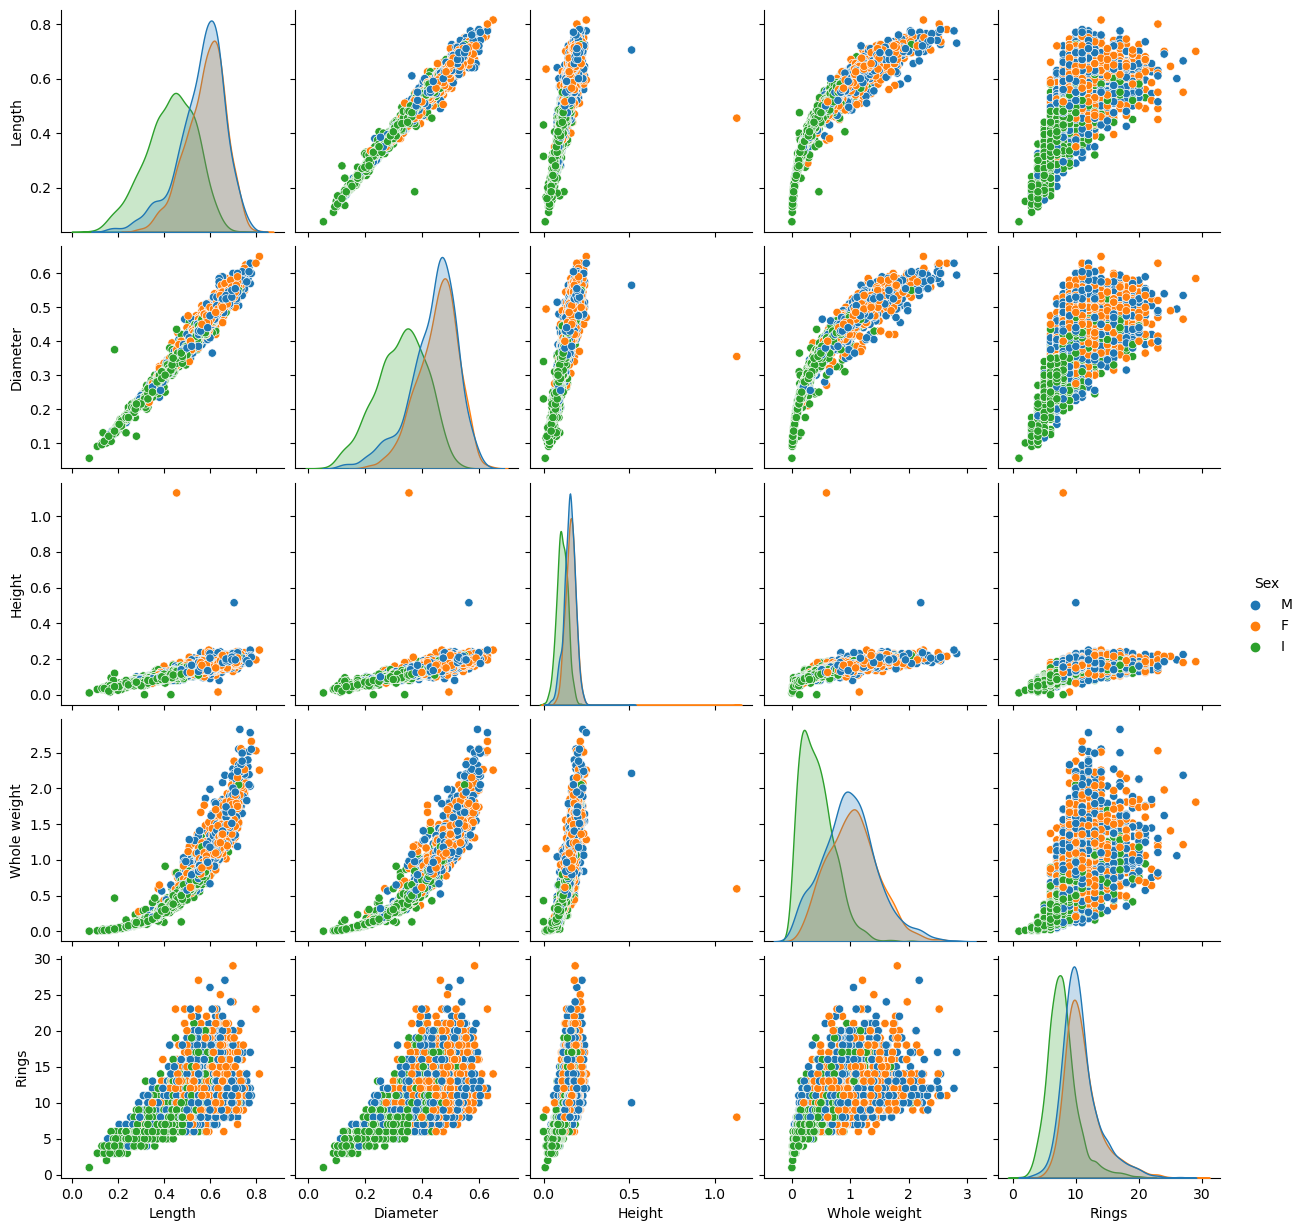

In [180]:
sns.pairplot(df,hue='Sex')

In [54]:
print(df.dtypes)

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


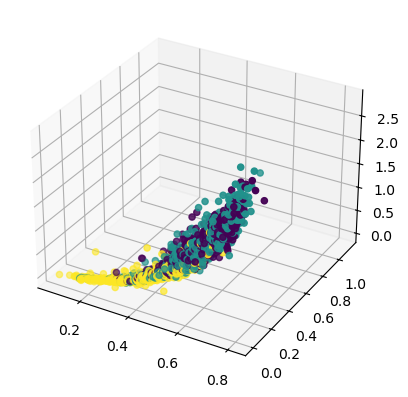

In [190]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = df['Sex'].map({'F':0, 'M':1, 'I':2})
ax.scatter(df['Length'],df['Height'],df['Whole weight'],c=colors);

In [147]:
X = df.drop('Sex',axis=1)
y = df['Sex']

In [141]:
col_drop=['Shucked weight','Viscera weight','Shell weight']
X = df.drop(col_drop,axis=1)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [151]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [153]:
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)

In [ ]:
LogisticRegression

In [210]:
penalty = ['l1', 'l2']
# Use logarithmically spaced C values (recommended in official docs)
C = np.logspace(0, 2, 20)

In [212]:
grid_model = GridSearchCV(log_model,param_grid={'C':C,'penalty':penalty})

In [214]:
grid_model.fit(scaled_X_train,y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ]),
                         'penalty': ['l1', 'l2']})

In [216]:
grid_model.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [218]:
y_pred = grid_model.predict(scaled_X_test)

In [220]:
accuracy_score(y_test,y_pred)

0.5765550239234449

In [222]:
confusion_matrix(y_test,y_pred)

array([[ 42,  23,  53],
       [  4, 122,  13],
       [ 47,  37,  77]])

In [224]:
cm = confusion_matrix(y_test, y_pred,normalize='true')

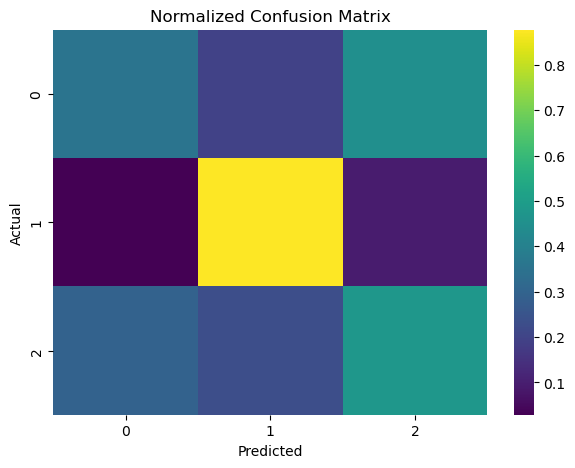

In [226]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=False, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

In [228]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           F       0.45      0.36      0.40       118
           I       0.67      0.88      0.76       139
           M       0.54      0.48      0.51       161

    accuracy                           0.58       418
   macro avg       0.55      0.57      0.55       418
weighted avg       0.56      0.58      0.56       418



In [177]:
accuracy_score(y_test,y_pred)

0.5765550239234449

In [237]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies 
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

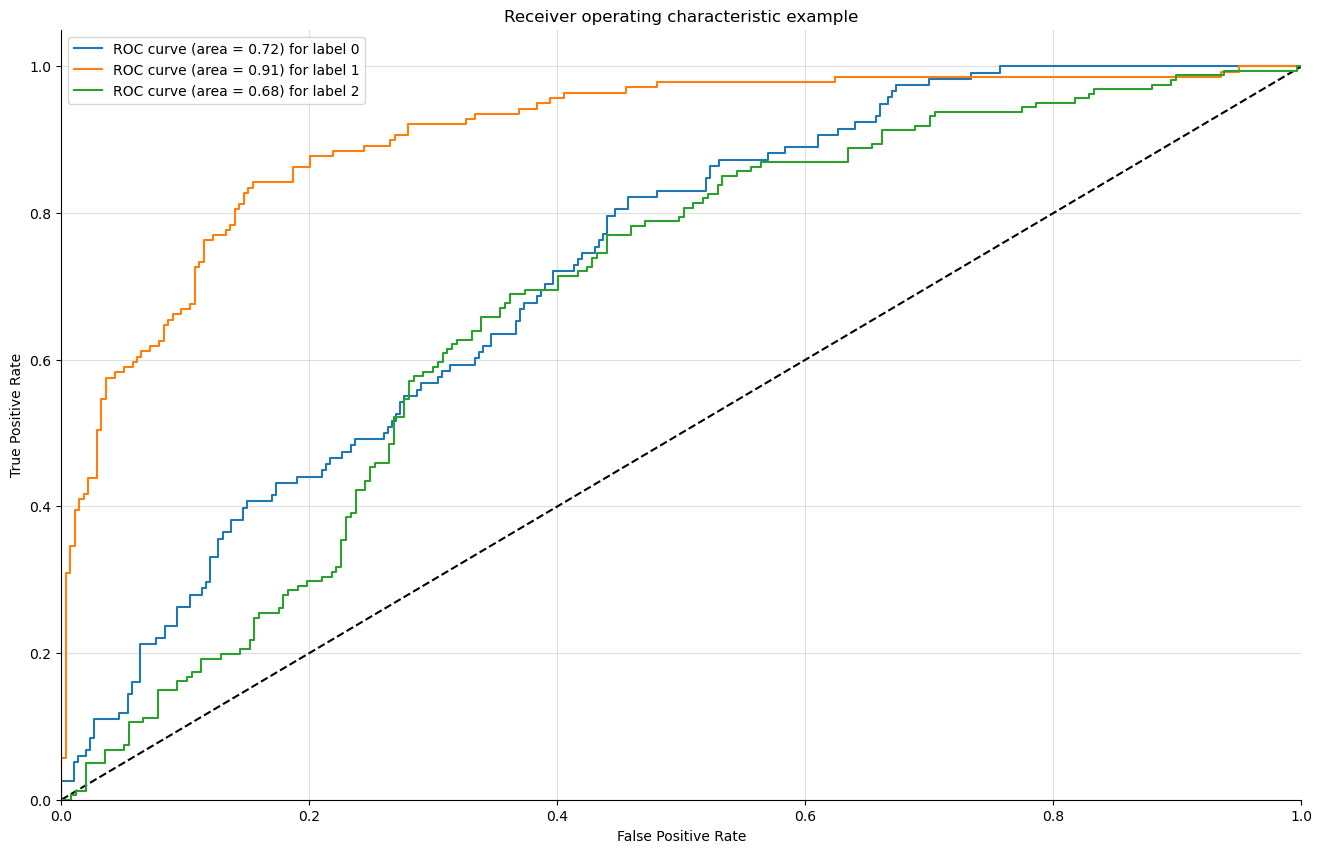

In [240]:
plot_multiclass_roc(grid_model, scaled_X_test, y_test, n_classes=3, figsize=(16, 10))